In [19]:
from scipy.signal import find_peaks
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from astropy.table import Table
from scipy.interpolate import CubicSpline
from datetime import datetime
import os
from astropy.table import Table
from astropy.io import ascii
from lightkurve import LightCurve
from lightkurve import LightkurveError
import time
from scipy.ndimage import median_filter

f_avoid = 3.5 / 372.5 #magic number
lc_exptime = (29.4) / (60 * 24) #days, see Kepler Data Processing Handbook, Section 3.1
sc_exptime = (58.8) / (60 * 60 * 24) #days, see Kepler Data Processing Handbook, Section 3.1

def get_kepler_data(kic_id, exptime='long'):
    
    start = time.time()
    """
    ## Inputs:
    `kic_id`: Kepler ID (str)
    `exptime`: default exposure time, 'long'

    ## Outputs:
    Returns a 4-tuple:
    - `lc`:  Lightkurve lc object (or nan if failed)
    - `delta_f`: frequency resolution, 1 / total observation time
    - `sampling_time`: median time between observations (in days)
    - `exptime`:  exposure time in days (from global `lc_exptime` or `sc_exptime`)

    ## Bugs:
    - Depends on global vals: `lc_exptime`, `sc_exptime` 
    - Fails silently when no data found
    - Rejects light curves where any `dt < 0.9 * median(dt)` — may be too strict
    - Uses magic thresholds for time sampling
    """
    print("starting to download data for", kic_id)

    search_result = lk.search_lightcurve(kic_id, mission = 'Kepler', exptime=exptime)
    if len(search_result) < 1:
        print(f"get_kepler_data(): no results for {kic_id} at this cadence")
        return np.nan, np.nan, np.nan, np.nan

    try:
        lc_collection = search_result.download_all()
    
    except LightkurveError:
        print(f"LightkurveError for {kic_id}: get_kepler_data(): search_result.download_all() failed for {kic_id}")
        return np.nan, np.nan, np.nan, np.nan
    lc = lc_collection.stitch()
    if check_inputs(lc.time.value) is False:
        time_val, __ = reorder_inputs(lc.time.value, lc.flux.value)
    else:
        time_val, __ = lc.time.value, lc.flux.value

    if not np.all(np.diff(time_val) > 0):
        print("nana.star(): times not in order")
        #raise ValueError("Times are not in order")
    delta_f = (1/(time_val[-1] - time_val[0]))
    sampling_time= np.median(np.diff(time_val))

    if not np.all(np.diff(time_val) > 0.90 * sampling_time): #magic
        print("nana.star(): some time intervals out of spec")
        print("nana.star(): median dt = ", sampling_time)
        #raise ValueError("some time intervals out of spec")
    
    exptime = np.nan
    if sampling_time > 0.9 * lc_exptime:  #magic number?
        exptime = lc_exptime
        print(f"{kic_id} is long cadence")
    if sampling_time < 1.1 * sc_exptime: #also magic number?
        exptime = sc_exptime
        print(f"{kic_id} is short cadence")
    if exptime is np.nan:
        print("nana.star(): no consistent exptime")
        #raise ValueError("no consistent exptime")
    print("nana.get_kepler_data() took", time.time() - start, "seconds")
    return lc, delta_f, sampling_time, exptime

def mask_vals(lc):
    """
    Remove mask values from a Lightkurve LightCurve object and return valid time, flux, and weight arrays.

    ## Inputs:
    `lc`: Lightkurve LightCurve object:
    - `

    ## Outputs:
    3 NumPy arrays:
    - `t_fit`: time values with valid (finite) data
    - `flux_fit`: corresponding flux values
    - `weight_fit`: corresponding weights (1 / sigma^2)

    ## Bugs:
    - not obvious that we need this function
    """
    #replaces masked values with NaN
    #print(type(lc.flux)) --> confirmed that lc.flux is a MaskedArray
    t_clean = np.ma.filled(lc.time.value, np.nan)
    flux_clean = np.ma.filled(lc.flux.value, np.nan)
    sigma_clean = np.ma.filled(lc.flux_err.value, np.nan)

    #gets rid of NaNs, creates mask with only finite/valid values
    mask = np.isfinite(t_clean) & np.isfinite(flux_clean) & np.isfinite(sigma_clean)
    t_fit = t_clean[mask]
    flux_fit = flux_clean[mask]
    sigma_fit = sigma_clean[mask]
    weight_fit = 1 / sigma_fit**2

    return t_fit, flux_fit, weight_fit

def check_inputs(xs):
    """
    ## Inputs:
    `xs`: list of lc time values (numpy array)

    ## Outputs:
    `bool`: `True` if the array is sorted, `False` otherwise
    """
    for i in range(len(xs) - 1):
        if xs[i] > xs[i + 1]:
            return False
    return True

def reorder_inputs(xs, ys):
    """
    ## Inputs:
    `xs`: lc time values (numpy array)  
    `ys`: lc flux values (numpy array)

    ## Outputs:
    A tuple `(xs_sorted, ys_sorted)` where:
    - `xs_sorted`: `xs` sorted in ascending order
    - `ys_sorted`: corresponding `ys` values reordered to match `xs_sorted`

    ## Bugs:
    - Assumes `xs` and `ys` are NumPy arrays
    - Raises a ValueError if `xs` and `ys` have different lengths
    """
    if len(xs) != len(ys):
        raise ValueError("reorder_inputs(): `xs` and `ys` must be the same length")
    i = np.argsort(xs)
    return xs[i], ys[i]

def get_periodogram(f_min, f_max, df, lc):
    """
    ## Inputs:
    `f_min`: minimum frequency (float, 1/day) — sets frequency resolution  
    `f_max`: maximum frequency (float, 1/day)  
    `lc`: Lightkurve LightCurve object

    ## Outputs:
    Two NumPy arrays:
    - `freq_full`: frequency grid (1/day)  
    - `power_full`: corresponding Lomb-Scargle power spectrum values

    ## Bugs:
    - Assumes `f_min` > 0 and `f_max` > `f_min`
    """
    
    frequency_grid = np.arange(f_min, f_max, df) / u.day
    pg = lc.to_periodogram(
        method='lombscargle',
        normalization='psd',
        frequency=frequency_grid
    )
    power = pg.power.value
    freq = pg.frequency.to(1 / u.day).value
    return freq, power

def design_matrix(xlist):
    """
    ## Inputs:
    `xlist`: numpy array of length 3 for the three frequency points (middle and two neighbors)

    ## Outputs:
    A 3x3 design matrix:
    - Column 1: constant term (1s)
    - Column 2: linear term (`xlist`)
    - Column 3: quadratic term with 0.5 factor (`0.5 * xlist**2`)

    ## Bugs:
    - Assumes `xlist` has length 3 
    - Assumes `xlist` is ordered

    ## Notes:
    - Includes a 0.5 factor that Hogg likes in the quadratic term 
    """
    return (np.vstack((xlist**0, xlist**1, 0.5 * xlist**2))).T

def fit_parabola(xs, ys, index):
    
    """
    ## Inputs:
    `xs`: numpy array of frequency values
    `ys`: numpy array of power values 
    `index`: integer index of the central point to fit around

    ## Outputs:
    Tuple `(b, m, q)` representing coefficients of the quadratic:  

    ## Bugs:
    - `xs` and `ys` must be numpy arrays
    - Index must not be 0 or `len(xs) - 1`; otherwise will be out of bounds
    """
    #index = int(index)
    if index < 1 or index > len(xs) - 2:
        raise IndexError("fit_parabola(): index must be between 1 and len(xs) - 2")
    return np.linalg.solve(design_matrix(xs[index-1:index+2]), ys[index-1:index+2])

def refine_peak(xs, ys, index):
    """
    ## Inputs:
    `xs`: numpy array of frequency values 
    `ys`: numpy array of power values
    `index`: integer index of peak to refine

    ## Outputs:
    3-tuple `(x_peak, y_peak, q)` where:
    - `x_peak`: refined x-position of the peak 
    - `y_peak`: refined y-position
    - `q`: second derivative

    ## Bugs:
    - Must be synchronized with the design matrix (uses same quadratic form)
    """
    b, m, q = fit_parabola(xs, ys, index)
    x_peak = -m / q
    if x_peak < xs[0] or x_peak > xs[-1]:
        return np.nan, np.nan, np.nan
    y_peak = 0.5 * q * x_peak**2 + m * x_peak + b
    return x_peak, y_peak, q

def refine_peaks(xs, ys, indices):
    """
    ## Inputs:
    `xs`: numpy array of frequency values
    `ys`: numpy array of power values
    `indices`: numpy array of frequency peak indices

    ## Outputs:
    Three NumPy arrays:
    - `xs_refined`: refined x positions of peaks
    - `ys_refined`: refined y positions of peaks
    - `second_derivatives`: curvature values (second derivative q for each peak)

    ## Bugs:
    - Assumes all `indices` are valid (i.e., between 1 and len(xs) - 2) 
    - Assumes `xs` and `ys` are numpy arrays and ordered
    """
    n = len(indices)
    xs_refined = np.full(n, np.nan)
    ys_refined = np.full(n, np.nan)
    second_derivatives = np.full(n, np.nan)
    
    for j, i in enumerate(indices):
        if np.isnan(i):
            continue
        else:
            result = refine_peak(xs, ys, i)
            x_r, y_r, q_r = result
            xs_refined[j] = x_r
            ys_refined[j] = y_r
            second_derivatives[j] = q_r
            
    return np.array(xs_refined), np.array(ys_refined), np.array(second_derivatives)

def get_filtered_peaks(num_of_peaks, xs, ys, median_window = None, median_factor = 20.): #median_factor is magic
    """
    ## Inputs:
    `num_of_peaks`: number of peaks to return  
    `xs`: numpy array of x values (frequencies)  
    `ys`: numpy array of y values (power spectrum)

    ## Outputs:
    NumPy array of peak indices (length ≤ `num_of_peaks`), filtered to avoid clustering and remove small peaks

    ## Bugs:
    - Depends on global variable `f_avoid`, which must be defined externally
    - Assumes `xs` is ordered and evenly spaced
    - No NaN handling in `ys`
    - uses append in a double loop
    """ 
    indxs, _ = find_peaks(ys)
    filtered = []

    if len(indxs) == 0:
        print("get_filtered_peaks(): no peaks found")
        return np.array(filtered)
    
    indices = indxs[np.argsort(-ys[indxs])]

    if median_window is not None:
        y_medians = median_filter(ys, size=median_window) #median window def magic
        too_short = ys[indices] < median_factor * y_medians[indices]
        indices = np.delete(indices, too_short)
    
    if len(indices) == 0:
        print("get_filtered_peaks(): no peaks tall enough")
        return np.array(filtered)

    #checks if the peak is within some threshold by comparing to those that already passed frequencies
    for index in indices:
        if all(abs(xs[index] - xs[fil]) >= f_avoid for fil in filtered):
            filtered.append(index)
            if len(filtered) == num_of_peaks:
                break
    return np.array(filtered)

def folding_freq(delta_f, fs, ps, sampling_time, makeplots=False):
    """
    ## Inputs:
    `delta_f`: frequency resolution
    `fs`: numpy array of frequency values 
    `ps`: numpy array of power values corresponding to `fs`  
    `sampling_time`: sampling interval in days  
    `makeplots`: bool, whether to plot

    ## Outputs:
    `fc`: refined estimate of the folding frequency

    ## Bugs:
    - Assumes `fs` is strictly ordered (required for spline and peak detection)
    - Removes first and last two points (`fsA = fsA[2:-2]`), assumes enough data
    """
    fc_guess = 1. / sampling_time
    IA = fs < 0.5 * fc_guess
    fsA, psA = fs[IA], ps[IA]
    fsA, psA = fsA[2:-2], psA[2:-2] #magic???

    cs = CubicSpline(fs, ps, extrapolate=False)

    small, tiny = 20 * delta_f, 0.25 * delta_f #magic
    fc_candidates = np.arange(fc_guess - small, fc_guess + small, tiny)
    #this should just be one line of numpy
    #check how much original powers from Region A match with the interpolated powers in Region A from fc_candidates
    foos_c = np.array([np.nansum(psA * cs(fc - fsA)) for fc in fc_candidates])
    fc_index = np.argmax(foos_c)
    fc, _, _ = refine_peak(fc_candidates, foos_c, fc_index)

    if makeplots:
        plt.plot(fc_candidates, foos_c)
        plt.axvline(fc_guess)
        plt.axvline(fc, color='red', alpha=0.5)
        plt.title(f"Refined folding frequency: {fc:0.5f}")
        plt.show()

    return fc

def find_min_and_refine(xs, ys):
    """
    ## Inputs:
    `xs`: numpy array of x values  
    `ys`: numpy array of y values 

    ## Outputs:
    Tuple `(refined_x, refined_y)` where:
    - `refined_x`: x-position of the refined minimum
    - `refined_y`: y-value at the refined minimum

    ## Bugs:
    - Assumes `xs` and `ys` are NumPy arrays of equal length
    - Assumes `xs` is ordered
    - Raises `ValueError` if no local minima are found
    - Raises `IndexError` if minimum is at the edge (index 0 or len-1)
    """
    #ys = np.asarray(list(ys))
    
    indxs, _ = find_peaks(-ys)

    if len(indxs) == 0:
        return np.nan, np.nan
        #raise ValueError("find_min_and_refine(): no local minima found")
    
    min_index = indxs[np.argsort(ys[indxs])[:1]]
    if min_index < 1 or min_index > len(xs) - 2:
        raise IndexError("find_min_and_refine(): minimum too close to edge to refine")
    
    refined_x, refined_y, _ = refine_peaks(xs, ys, min_index)
    return refined_x[0], refined_y[0]

def integral_design_matrix(ts, om, T):
    """
    ## Inputs:
    `ts`: list of N times (days)
    `om`: angular frequency (inverse days)
    `T`: exposure time (days)

    ## Outputs:
    `X`: Nx3 design matrix

    ## Bugs:
    - Assumes all data points have the same exposure time `T`
    - Not numerically stable when `om * T` is small
    """
    return np.vstack([
        np.ones_like(ts),
        (np.sin(om * (ts + T / 2)) - np.sin(om * (ts - T / 2))) / (om * T),
        (-np.cos(om * (ts + T / 2)) + np.cos(om * (ts - T / 2))) / (om * T)
    ]).T

def weighted_least_squares(A, b, weights):
    """
    ## Inputs:
    `A`: NxM design matrix (NumPy array)  
    `b`: N-length observation vector (NumPy array)  
    `weights`: N-length vector of weights (NumPy array), applied per row

    ## Outputs:
    N-length fitted model values `A @ x`, where `x` solves the weighted least squares problem

    ## Bugs:
    - Assumes all inputs are NumPy arrays of compatible shape
    """

    ATA = A.T @ (A * weights[:, np.newaxis])
    ATb = A.T @ (b * weights)
    return np.linalg.solve(ATA, ATb)

def integral_chi_squared(om, ts, ys, ws, T):
    """
    ## Inputs:
    `om`: angular frequency (in inverse days)  
    `ts`: numpy array of observation times (in days)  
    `ys`: numpy array of observed flux values  
    `ws`: numpy array of weights (same length as `ts` and `ys`)  
    `T`: exposure time (in days)

    ## Outputs:
    Weighted chi-squared value computed using the integral design matrix model

    ## Bugs:
    - Assumes all inputs are NumPy arrays of compatible shapes
    - Assumes uniform exposure time `T` for all observations
    - Numerically unstable when `om * T` is small (from `integral_design_matrix`)
    """
    A = integral_design_matrix(ts, om, T)
    return np.sum(ws * (ys - (A @ weighted_least_squares(A, ys, ws)))**2)


def region_and_freq(indices, folding_freq, f_min, unrefined_freq, unrefined_power, t_fit, flux_fit, weight_fit, T):
    start = time.time()

    """
    ## Inputs:
    `indices`: array of peak indices
    `folding_freq`: folding frequency   
    `df`: frequency resolution
    `unrefined_freq`: array of frequency values  
    `unrefined_power`: power spectrum values corresponding to `unrefined_freq`  
    `t_fit`: time values used for model fitting  
    `flux_fit`: observed signal (e.g., flux)  
    `weight_fit`: weights for fitting  
    `T`: exposure time in days

    ## Outputs:
    Three NumPy arrays:
    - `regions`: array of region labels (`"A"`, `"B"`, `"C"`)
    - `best_freqs`: refined frequency values for each peak
    - `best_chi2s`: corresponding chi-squared values

    ## Bugs:
    - Assumes `refine_peaks` succeeds for all given indices
    - No handling if `fine_freqsX` are empty or out of bounds
    - probably this should just run on one index at a time, and the loop over indices should ne in the calling function
    """
    valid_locs = [j for j, val in enumerate(indices) if not np.isnan(val)]
    valid_indices = [indices[j] for j in valid_locs]
    
    N = len(indices)
    regions = np.full(N, np.nan, dtype=object)
    best_freqs = np.full(N, np.nan)
    best_chi2s = np.full(N, np.nan)

    fas, _, _ = refine_peaks(unrefined_freq, unrefined_power, valid_indices)
    
    A, B, C = fas, folding_freq - fas, folding_freq + fas

    for i, loc in enumerate(valid_locs):
        fine_freqsA = np.arange(A[i] - 5 * f_min, A[i] + 5 * f_min, 0.2 * f_min) #magic, and so are all fine_freqs
        #chi2_fineA = np.array([integral_chi_squared(2 * np.pi * f, t_fit, flux_fit, weight_fit, T) for f in fine_freqsA])
        #print("chi2_fineA", chi2_fineA)
        chi2_fineA = np.array([integral_chi_squared(2 * np.pi * f, t_fit, flux_fit, weight_fit, T) for f in fine_freqsA])

        #print("chi2_fineA", chi2_fineA)
        best_freqA, best_chi2A = find_min_and_refine(fine_freqsA, chi2_fineA)

        fine_freqsB = np.arange(B[i] - 5 * f_min, B[i] + 5 * f_min, 0.2 * f_min)
        chi2_fineB = np.array([integral_chi_squared(2 * np.pi * f, t_fit, flux_fit, weight_fit, T) for f in fine_freqsB])
        best_freqB, best_chi2B = find_min_and_refine(fine_freqsB, chi2_fineB)

        fine_freqsC = np.arange(C[i] - 5 * f_min, C[i] + 5 * f_min, 0.2 * f_min)
        chi2_fineC = np.array([integral_chi_squared(2 * np.pi * f, t_fit, flux_fit, weight_fit, T) for f in fine_freqsC])
        best_freqC, best_chi2C = find_min_and_refine(fine_freqsC, chi2_fineC)

        freqs = np.array([best_freqA, best_freqB, best_freqC])
        chi2s = np.array([best_chi2A, best_chi2B, best_chi2C])
        regs = np.array(['A', 'B', 'C'])

        no_nans = ~np.isnan(chi2s)

        if np.any(no_nans):
            freqs = freqs[no_nans]
            chi2s = chi2s[no_nans]
            regs = regs[no_nans]

            low_chi_ind = np.argmin(chi2s)
            regions[loc] = regs[low_chi_ind]
            best_freqs[loc] = freqs[low_chi_ind]
            best_chi2s[loc] = chi2s[low_chi_ind]
    print("region_and_freq() took", time.time() - start, "seconds")

    delta_chi2s =  null_chi_squared(flux_fit, weight_fit) - best_chi2s

    output_table = Table()
    output_table['frequency'] = best_freqs
    output_table['region'] = regions
    output_table['delta chi-squared'] = delta_chi2s
    output_table['frequency in region A'] = fas

    return output_table
    #return regions, best_freqs, best_chi2s

def sharpness(second_derivatives, y_news):
    """
    ## Inputs:
    `second_derivatives`: NumPy array of second derivatives
    `y_news`: NumPy array of peak heights or values at the vertex of the parabola

    ## Outputs:
    NumPy array of sharpness values, defined as sqrt(-q / y)

    ## Bugs:
    - Assumes `y_news` and `second_derivatives` are same-length NumPy arrays
    - Assumes `y_news` ≠ 0 and `second_derivatives` < 0 (for real output)
    """

    second_derivatives = np.asarray(second_derivatives)
    y_news = np.asarray(y_news)
    N = len(second_derivatives)

    sharps = np.full(N, np.nan)
    for i in range(N):
        if np.isnan(second_derivatives[i]) or np.isnan(y_news[i]):            
            sharps[i] = (-second_derivatives[i] / y_news[i]) ** 0.5

    return sharps


def null_chi_squared(ys, weights):
    """
    ## Inputs:
    `ys`: numpy array of observed values (e.g., flux)  
    `weights`: numpy array of weights corresponding to `ys`

    ## Outputs:
    `null_chisq`: weighted chi-squared value

    ## Bugs:
    - Assumes `ys` and `weights` are NumPy arrays of the same length
    - Raises `ZeroDivisionError` if the sum of weights is zero 
    """
    total_weight = np.sum(weights)
    if total_weight == 0:
        raise ZeroDivisionError("null_chi_squared(): sum of weights is zero")
    
    a0 = np.sum(weights * ys) / total_weight
    null_chisq = np.sum(weights * (ys - a0) ** 2)
    return np.array(null_chisq)

def splitting(ts, K, jackknife = True):
    '''
    # splitting()
    Produce either disjoint or jackknife subsamples.
    
    ## Inputs:
    - `ts`: shape `(N, )` array of times (not necesarily ordered)
    - `K`: number of subsamples to return
    - `jackknife`: `True` for jackknife subsamples; otherwise disjoint
    
    ## Output: 
    - `masks`: shape `(K, N)` boolean array; `True` if in subsample

    ## Comment:
    - Relies on numpy conventions about relationships between integers and bools.
    '''
    N = len(ts)
    indices = np.argsort(ts)
    split_indices = np.array_split(indices, K)
    if jackknife:
        masks = np.ones((K, N), dtype=bool) # make everything True by default
        for i, idx in enumerate(split_indices):
            masks[i, idx] = False # remove subsample
    else:
        masks = np.zeros((K, N), dtype=bool) # make everything False by default
        for i, idx in enumerate(split_indices):
            masks[i, idx] = True # add subsample
    return masks

def check_coherence(ts, ys, weights, T, output_table):
    '''
    ## Inputs:
    - `ts`: time values 
    - `ys`: flux values 
    - `weights`: weights for the observations 
    - `final_freq`: final frequencies to check coherence for 
    - `T`: exposure time 

    ## Outputs:
   - `all`: shape `(N, 2)` array of a,b pars fit over full data
    - `half`: shape `(N, 2, 2)` a,b pars fits over halves
    - `quarter`: shape `(N, 4, 2)` a,b pars fits over quarters
    - `eighth`: shape `(N, 8, 2)` a,b pars fits over eighths +(jackknife)
    '''
    final_freq = output_table["frequency"]
    N = len(final_freq)
    all = np.full((N, 2), np.nan)
        

    splits = np.array([2, 4, 8])
    results = [np.full((N, n, 2), np.nan) for n in splits]
    
    for idx, f in enumerate(final_freq):
        if np.isnan(f):
            continue
        om = f * 2 * np.pi 
        A = integral_design_matrix(ts, om, T)
        pars = weighted_least_squares(A, ys, weights)
        all[idx][0] = pars[1]
        all[idx][1] = pars[2]

    for split, result in zip(splits, results):     

        jack = (split == 8)
        masks = splitting(ts, split, jackknife = jack)
        for idx, f in enumerate(final_freq):
            if np.isnan(f):
                continue
            om = f * 2 * np.pi
            for i, mask in enumerate(masks):
                A = integral_design_matrix(ts[mask], om, T)
                pars = weighted_least_squares(A, ys[mask], weights[mask])
                result[idx][i][0] = pars[1] #a
                result[idx][i][1] = pars[2] #b

    return all, results[0], results[1], results[2] #all, half, quarter, eighth (+jacknives)


def sampling_stats(alls, halves, quartiles, eighths, ts, output_table):
    '''
    sampling_stats():
    Calculate  statistics on oscillation amplitude and phase
    ## Inputs:
    - `all`: shape `(N, 2)` array of a,b pars fit over full data
    - `half`: shape `(N, 2, 2)` a,b pars fits over halves
    - `quarter`: shape `(N, 4, 2)` a,b pars fits over quarters
    - `eighth`: shape `(N, 8, 2)` a,b pars fits over eighths +(jackknife)
    - `ts`: time values

    ## Outputs:
    - `amp_change2`:  array of log-amplitude change rates from halves
    - `phase_change2`: array of phase change rates from halves
    - `amp_change4`: (N, 4)` relative log amplitude changes from quartiles
    - `phase_change4`: (N, 4)` relative phase shifts from quartiles
    - `sigma_lnA4`:  array of ln-amplitude across quartiles (1/2 RMS)
    - `sigma_phi4`:  array of phase across quartiles (1/2 RMS)
    - `sigma_phij`:  array of phase from jackknife eighths (sigma estimate)

    ## Comment:
    - halves statsitics are calculated from comparison between the first and second halves parameters
    - quartiles and eighth jacknife stats
      are calculated from relative shift from the all parameters to the quartile and eighth parameters
    '''

    f_num = len(alls)
    ts_median = np.median(ts)
    delta_t = np.median(ts[ts > ts_median]) - np.median(ts[ts < ts_median])
    amp_change2 = np.full((f_num), np.nan)
    phase_change2 = np.full((f_num), np.nan)
    
    amp_change4 = np.full((f_num, 4), np.nan) #change in rate of ln(amp) for quartile
    phase_change4 = np.full((f_num, 4), np.nan) #change in rate of phase for quartile

    sigma_lnA4 = np.full(f_num, np.nan) # 1/2 rms lnA for quartile
    sigma_phi4 = np.full(f_num, np.nan) # 1/2 rms phase for quartile
    sigma_phij = np.full(f_num, np.nan) #sigma phi for jacknife
    
    for inx, (all, half, quartile, eighth) in enumerate(zip(alls, halves, quartiles, eighths)):

        #change in rate of ln(a) and phase calcualtion for halves
        
        a1, b1, a2, b2 = half[0][0], half[0][1], half[1][0], half[1][1]
        if any(np.isnan([a1, a2, b1, b2])):
            continue
        delta_r = [a2 - a1, b2 - b1]
        vector_r = [0.5 * (a2 + a1), 0.5 * (b2 + b1)]
        cross_z = delta_r[0] * vector_r[1] - delta_r[1] * vector_r[0]
        dot_r = np.dot(vector_r, vector_r)

        phase_change2[inx] = (1 / delta_t) * (cross_z / dot_r)
        amp_change2[inx]   = (1 / delta_t) * (np.dot(delta_r, vector_r) / dot_r)


        #quartile and jacknife calcualtions
        deltak_4 = np.zeros((4,2))
        deltak_j = np.zeros((8,2))
        a,b = all[0], all[1]
        if np.isnan(a) or np.isnan(b):
            continue
        
        for i, q in enumerate(quartile):   
            deltak_4[i] = [a - q[0], b - q[1]]

        for i, j in enumerate(eighth):   
            deltak_j[i] = [a - j[0], b - j[1]]
                
        x = np.array([a,b])
        x_norm = np.linalg.norm([a, b])
        x_hat = x / x_norm
        y_hat = [x_hat[1], - x_hat[0]]

        amp4 = np.dot(deltak_4, x_hat)/ x_norm
        phase4 = np.dot(deltak_4, y_hat)/x_norm
        phasej = np.dot(deltak_j, y_hat)/x_norm

        var_lnA = 0.5 * np.sqrt(np.mean(amp4 ** 2))#1/2 rms lnA
        varphi4 = 0.5 * np.sqrt(np.mean(phase4 ** 2)) #1/2 rms phase

        varphij = np.sqrt((7/8) * np.sum(phasej ** 2)) #sigma phi

        amp_change4[inx] = amp4
        phase_change4[inx] = phase4

        sigma_lnA4[inx] = var_lnA
        sigma_phi4[inx] = varphi4
        sigma_phij[inx] = varphij
    
    #make astropy table
    #print(sigma_phij.shape)
    output_table.add_columns([sigma_phij,  sigma_phi4, phase_change2, phase_change4], names = ['phase uncertainty jackknife', 'phase uncertainty split', 'phase change for A-B split', 'phase change for quartile split'])
    #print("output table adding columns", output_table)
    return output_table

def inject_one_mode(ts, ys, T, in_pars):
    '''
    # inject_one_mode()
    adds a mode

    ## Inputs:
    - `ts`: array of time values
    - `ys`: array of flux values (original signal)
    - `T`:  exposure time 
    - `in_pars`: tuple `(f, a, b)`:
        - `f`: frequency to inject 
        - `a`, `b`: cosine and sine pars

    ## Output:
    - `yin`: `(N,)` array of modified flux values with injected mode
    '''
    #yin is the new fluxfit
    fin, ain, bin = in_pars
    inject_vec = np.array([0.0, ain, bin])   

    xin = integral_design_matrix(ts, 2 * np.pi * fin, T)
    yin = ys + xin @ inject_vec  
    
    return yin 

def RunningMedian(x, N):
    return median_filter(x, N)

    #return np.array([np.median(c) for c in b])  # This also works

def find_modes_in_star(kicID, plots = False, save = False, inject_rng = None, inject_amp = 0.01, 
                       max_peaks = 24, chi2_threshold = 100, phase_uncertainty_threshold = 0.1, 
                       median_window = 21, median_factor = 20.): #basically all magic here
    
    start = time.time()
    
    #get the lightcurve
    print(f"kic id {kicID}")
    lc, delta_f, sampling_time, exptime = get_kepler_data(kicID)

    if np.isnan(delta_f):
        print(f"Skipping {kicID} because get_kepler_data() returned nans")
        return None
    
    t_fit, flux_fit, weight_fit = mask_vals(lc) 

    #set frequency variables  
    over_sampling  = 3 #oversample by a factor of 3
    df, f_maxC = delta_f/over_sampling, (3 / (2*sampling_time))
    f_min = over_sampling * df
    
    
    #get periodograms in regions A, B, and C
    freq_full, power_full = get_periodogram(f_min, f_maxC, df, lc)
    fc = folding_freq(delta_f, freq_full, power_full, sampling_time, False)
    fb = 0.5 * fc
    freq_mini, power_mini = get_periodogram(f_min, fb, df, lc)

    RunningMedian_power = RunningMedian(power_mini, 31) #31 is magic

    #find periodogram peaks in region A
    indices = get_filtered_peaks(max_peaks, freq_mini, power_mini/RunningMedian_power, 
                                 median_window = median_window, median_factor = median_factor)
    if len(indices) == 0:
        print(f"No peaks found in {kicID}")
        return None
    
    #find frequencies and corresponding regions
    output_table = region_and_freq(indices, fc, df, freq_mini, power_mini, t_fit, flux_fit, weight_fit, exptime)


    good = ~np.isnan(output_table["frequency"]) & (output_table["delta chi-squared"] >= chi2_threshold) #filter out bad regions and low chi2
    if np.sum(good) < 1:
        print(f"No frequencies found in {kicID} with chi2 threshold {chi2_threshold}")
        return None 
    output_table = output_table[good]
    
    all, half, quartiles, eighths = check_coherence(t_fit, flux_fit, weight_fit, exptime, output_table)

    output_table = sampling_stats(all, half, quartiles, eighths, t_fit, output_table)
    
    good = (output_table['phase uncertainty jackknife'] <  phase_uncertainty_threshold)
    if np.sum(good) < 1:
        print(f"No modes found in {kicID} with phase uncertainty threshold {phase_uncertainty_threshold}")
        return None
    output_table = output_table[good]
    
    #full periodogram plotting (requires final_freqs)
    if plots:
        plt.plot(freq_full, power_full, 'k.', markersize = 1, alpha = 0.5)
        for freq in output_table["frequency"]:
            plt.axvline(freq, color='red', alpha=0.50, lw = 0.5)
        plt.xlabel("Frequency (1/day)")
        plt.ylabel("Power")
        plt.title("Frequencies that make chi2 cut")
        plt.axvline(fc)
        plt.axvline(fc/2)
        plt.semilogy()
        plt.title(f"Full Periodogram of {kicID}")
        if save:
            #plt.savefig(os.path.join(output_dir, f"{kicID}_fullperio.png"))
            plt.savefig(f"{kicID}_fullperio.png")
        plt.show()   
    
    sigma_phi4 = output_table['phase uncertainty split']
    sigma_phij = output_table['phase uncertainty jackknife']
    final_freqs = output_table['frequency']
    phase_change2 = output_table[ 'phase change for A-B split']
    phase_change4 = output_table['phase change for quartile split']
    regions = output_table['region']
    delta_chi2s = output_table['delta chi-squared']
    fas = output_table['frequency in region A']
    
    #sigmaphi plotting
    if plots:
        plt.scatter(sigma_phi4, sigma_phij, c = delta_chi2s, marker = 'o', s = 10, label = 'delta chi >= 100', cmap = "viridis")
        plt.title(f"sigma phi for {kicID}")
        plt.xlabel("sigma phis for quartiles")
        plt.ylabel("sigma phis for jackknives")
        plt.axvline(0.1, color = 'pink')
        plt.axhline(0.1, color = 'pink')
        plt.axvline(0.01, color = 'sandybrown')
        plt.axhline(0.01, color = 'sandybrown')
        plt.loglog()
        plt.colorbar()
        
        if save:
            plt.savefig(f"{kicID}_phase_uncertainity_plot.png")
        plt.show()

    #15 point graph plotting
    if plots:
    
        fig, axes = plt.subplots(3, 4, figsize=(16, 9))
        plt.suptitle(f"15 Point figure of {kicID}", fontsize = 18)
        
        for idx, (ax, points1, points2, points3, points4, p1, p2, p3, p4) in enumerate(zip(axes.flat, all, half, quartiles, eighths, phase_change2, 
                                                                                           sigma_phi4, sigma_phij, phase_change4)):
            if (np.isnan(points1).any() or np.isnan(points2).any() or np.isnan(points3).any() or np.isnan(points4).any()):                
                ax.set_visible(False)
                continue
            
            try:
                a_all = points1[0]
                b_all = points1[1]
        
                a_half = [row[0] for row in points2 if not np.isnan(row[0]) and not np.isnan(row[1])]
                b_half = [row[1] for row in points2 if not np.isnan(row[0]) and not np.isnan(row[1])]

                a_quarter = [row[0] for row in points3 if not np.isnan(row[0]) and not np.isnan(row[1])]
                b_quarter = [row[1] for row in points3 if not np.isnan(row[0]) and not np.isnan(row[1])]

                a_eighth = [row[0] for row in points4 if not np.isnan(row[0]) and not np.isnan(row[1])]
                b_eighth = [row[1] for row in points4 if not np.isnan(row[0]) and not np.isnan(row[1])]     
        
                ax.scatter(a_half, b_half, color='orange', marker='*')
                ax.scatter(a_quarter, b_quarter, color='blue', marker='+')
                ax.scatter(a_eighth, b_eighth, color='k', marker='.')
                ax.scatter(a_all, b_all, color='red', marker='x')
        
                p1_str = f"{p1:0.8e}" if not np.isnan(p1) else "None"
                p2_str = f"{p2:0.8e}" if not np.isnan(p2) else "None"
                p3_str = f"{p3:0.8e}" if not np.isnan(p3) else "None"
        
                ax.text(0.05, 0.95, f"phase change(2): {p1_str}", transform=ax.transAxes,
                        fontsize=8, verticalalignment='top', color='green')
                ax.text(0.05, 0.88, f"sigma phi(4): {p2_str}", transform=ax.transAxes,
                        fontsize=8, verticalalignment='top', color='green')
                ax.text(0.05, 0.81, f"sigma phi(jack): {p3_str}", transform=ax.transAxes,
                        fontsize=8, verticalalignment='top', color='green')
        
                freq_label = f"{final_freqs[idx]:0.8f}" if not np.isnan(final_freqs[idx]) else "None"
                ax.set_title(freq_label)
        
                ax.axvline(0, color='k')
                ax.axhline(0, color='k')
                ax.set_xlabel("a points")
                ax.set_ylabel("b points")
                ax.grid(True)
                ax.ticklabel_format(style='sci', scilimits=(-3, 3), axis='both')
                ax.axis('equal')
                
        
            except Exception as e:
                ax.set_visible(False)
                continue

        
        plt.tight_layout()
        if save:
            #plt.savefig(os.path.join(output_dir, f"{kicID}_15point.png"))
            plt.savefig(f"{kicID}_15point.png")
        plt.show()
        plt.close(fig)
        
    print("find_modes_in_star() finished processing star", kicID)
    print("Found modes length:", len(final_freqs))
    
    #print("Final frequencies:", final_freqs)
    #save to csv
    output_table.remove_column('phase change for quartile split')
    output_table.remove_column('phase change for A-B split')


    output_table.add_column( ([kicID, ] * len(final_freqs)), name = 'KIC', index = 0)

    if save:

        print("find_modes_in_star() saving results for", kicID)
        
    
        ascii.write(
        output_table,
        kicID + '_random_stats' + '.csv',
        overwrite=True,
        format="csv",
        formats={
            "frequency": "{:.7f}",
            "region": "{}",
            "delta chi-squared": "{:.7e}",
            "frequency in region A": "{:.7f}",
            "phase uncertainty jackknife" : "{:.7e}",
            "phase uncertainty split": "{:.7e}",
        }
        )
            

            #magic numbers

            #for peak finding function
                #f_avoid = 3.5 / 372.5
                #def get_filtered_peaks(num_of_peaks, xs, ys, median_window = None, median_factor = 10.)
                #median_factor = 
                #median_window = 21
            
            
            #sampling times characterizing (not magic number)
            # if sampling_time > 0.9 * lc_exptime:
            #     exptime = lc_exptime
            # if sampling_time < 1.1 * sc_exptime:
            #     exptime = sc_exptime

            #finding folding frequency, the refined frequency and its region function
            # small, tiny = 20 * delta_f, 0.25 * delta_f #magic
            # fc_candidates = np.arange(fc_guess - small, fc_guess + small, tiny), these are folding freuqnecy candidates
            #fine_freqsA = np.arange(A[i] - 5 * f_min, A[i] + 5 * f_min, 0.2 * f_min), the are the chi square min frequency candidates
            

            #running median
            #RunningMedian_power = RunningMedian(power_mini, 31)


            #thresholds to determine if qualified frequency
            #chi2_threshold = 100
            #phase_uncertainty_threshold = 0.1

            #maxpeaks = 100
    
    # if final_freqs is not None and len(final_freqs) > 0:
    #     return output_table
    #     return None

kic id KIC000757450
starting to download data for KIC000757450
KIC000757450 is long cadence
nana.get_kepler_data() took 0.5917220115661621 seconds
region_and_freq() took 7.1509130001068115 seconds


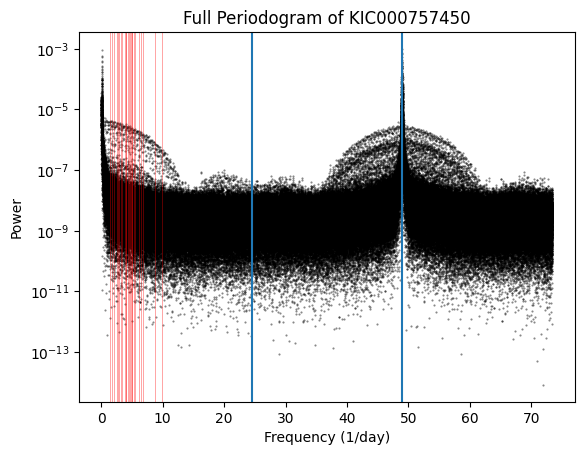

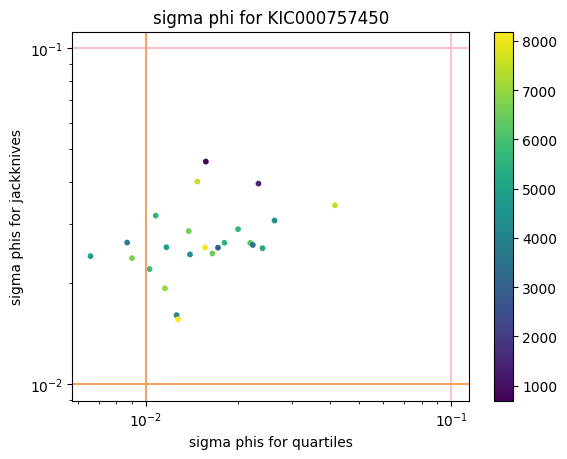

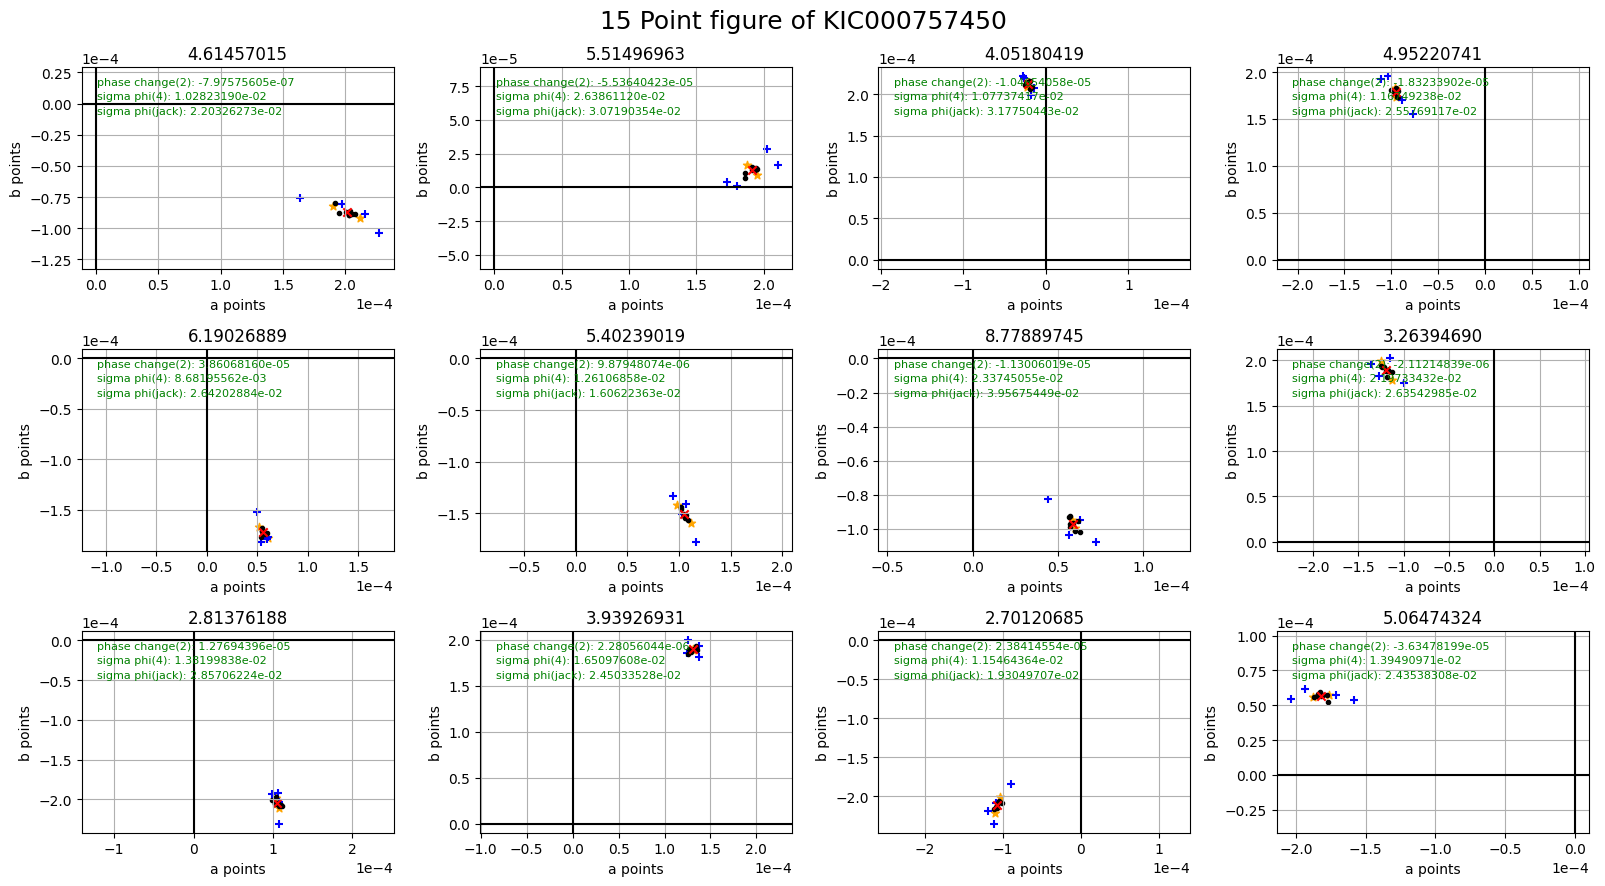

find_modes_in_star() finished processing star KIC000757450
Found modes length: 24


In [20]:
find_modes_in_star("KIC000757450", plots = True)